### Introduction
Tennis is a highly competitive sport with many professionals starting at a young age. Furthermore, it is notorious for having an early retirement age compared to other sports. Many professional tennis player retire before 30, but popular players have retired at a much later age. With such an emphasis on age and success, our project aims to answer if age predicts success among the Top 500 tennis players. Using the "Player Stats for Top 500 Players" data set from https://www.ultimatetennisstatistics.com, the team selected only the age, current rank, current elo rank, and prize money (total accumulated earnings) variables from the .csv file.

We have chosen to assess a player's current rank as opposed to their best rank in order to reflect their current age in the ranking decision. Furthermore, Rank refers to an accumulation of points scored by a player across various different tournaments while Elo Rank is a comparative ranking that gauges a player's skill against their opponents. For example, a player who competes in lower-level tournaments may have a high rank but not necessarily a high elo rank. Looking at both ranking systems can help us determine the skill and ultimate success of a player.


### Methods
We first cleaned and wrangled the variables into a tidydata format. We then split the data into training and testing sets. We then visualized variables of the training set by creating three individual scatter plots with age on the x-axis and the current rank, current elo rank, or prize money on the y-axis respectively. 


Afterwards, we will use Knn regression to see if age can predict values of current rank, current elo rank, and prize money. We will achieve this by using the training data set to run a cross-validation to choose the best K parameter, and train and fit the model. Then, we will use the testing data set to evaluate our model's performance. We will then visualize the results by creating six individual graphs (three histograms and three scatter plots) of the original data set, all with a trend line representing our model's regression predictions, and age on the x-axis and the current rank, current elo rank, or prize money each on the y-axis. The histogram will have bins distributed by age group. 

### Expected Outcomes and Significance
We expect to find that players in their early to mid-twenties will have a higher current rank and current elo rank while players of an older age will have higher prize money. Tennis players could use this data to assess their  earnings at any given age and better plan for their career's future.

Further research might include how other variables in the same data set (such as height and number of years gone professional) as well as other possible variables outside this data set (such as number of years spent training or costs spent on training) change the relationship between age and success. 


In [1]:

library(tidyverse)
install.packages("janitor")
library(janitor)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ─

In [25]:
#Reads the data of the Top 500 Tennis Players
player_data <- read_csv("https://raw.githubusercontent.com/lukeelliotchan/dsci100_grp35/main/player_stats.csv") |>
    clean_names()

#Seperates values in cells and makes the format tidy
player_data_tidy <- player_data |>
    separate(current_rank, c("current_rank", "points"), " ") |>
    separate(current_elo_rank, c("current_elo_rank", "current_elo"), " ") |>
    separate(age, c("age", "dob"), " ") |>
    separate(prize_money, c("dollar", "prize_money"), "\\$") |>
    separate(prize_money, c("prize_money", "temp"), "  ") |>
    select(current_rank, current_elo_rank, prize_money, age)

head(player_data_tidy)

#Cleans erroneous text and irrelevant information
player_data_cleaned <- player_data_tidy |>
    mutate(current_rank = as.numeric(current_rank)) |> 
        #turn the columns into numbers
    mutate(prize_money = as.numeric(gsub(",", "", prize_money))) |> 
        #rows that dont meet condition of becoming number are just NA, will fix later
    mutate(current_elo_rank = gsub("\\(", "", current_elo_rank)) |>
    mutate(current_elo_rank = as.numeric(gsub("\\)","", current_elo_rank)))   |>                                      
    mutate(age = as.numeric(age))

head(player_data_cleaned)

#Splits the data into training and testing sets
data_split <- initial_split(player_data_cleaned, prop = 0.75, strata = prize_money)
player_training <- training(data_split)
player_testing <- testing(data_split)

head(player_training)

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Expected 2 pieces. Additional pieces discarded in 2 rows [146, 441].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 412 rows [2, 3, 4, 5, 6,
7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22, 23, ...].”


current_rank,current_elo_rank,prize_money,age
<chr>,<chr>,<chr>,<chr>
378,NA,NA,26
326,NA,"59,040",18
178,144,"3,261,567",32
236,NA,"374,093",21
183,100,"6,091,971",27
31,33,"1,517,157",22


Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `prize_money = as.numeric(gsub(",", "", prize_money))`.
Caused by warning:
! NAs introduced by coercion”


current_rank,current_elo_rank,prize_money,age
<dbl>,<dbl>,<dbl>,<dbl>
378,NA,NA,26
326,NA,59040,18
178,144,3261567,32
236,NA,374093,21
183,100,6091971,27
31,33,1517157,22


current_rank,current_elo_rank,prize_money,age
<dbl>,<dbl>,<dbl>,<dbl>
378,NA,NA,26
326,NA,59040,18
232,NA,59123,21
417,189,122734,25
104,NA,74927,20
431,NA,54004,23


Warning message:
“Removed 76 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 5 rows containing missing values (`geom_point()`).”


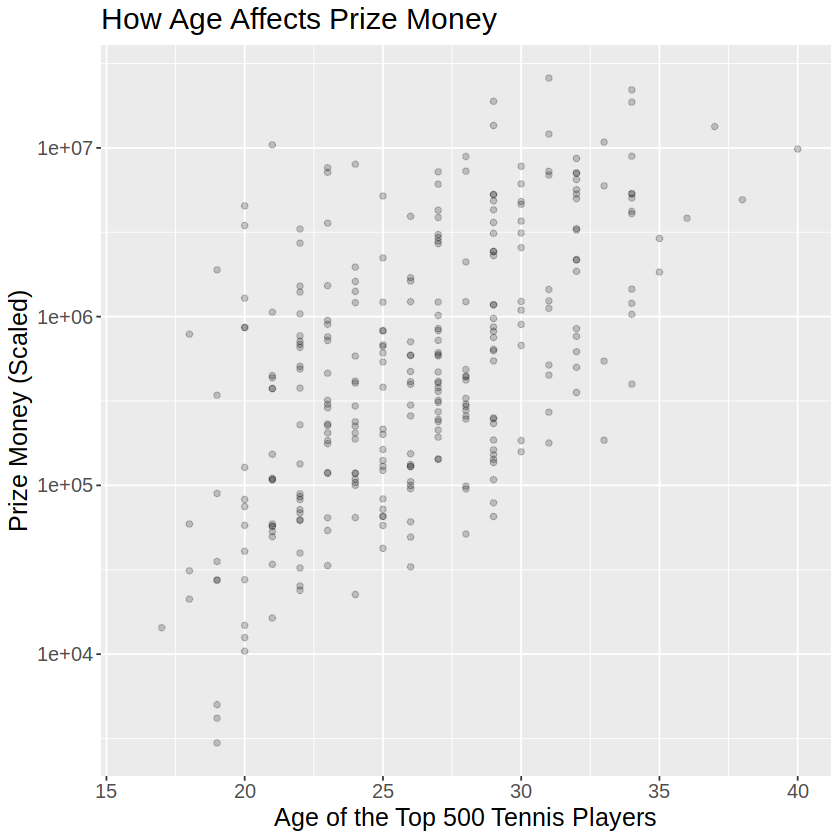

Warning message:
“Removed 239 rows containing missing values (`geom_point()`).”


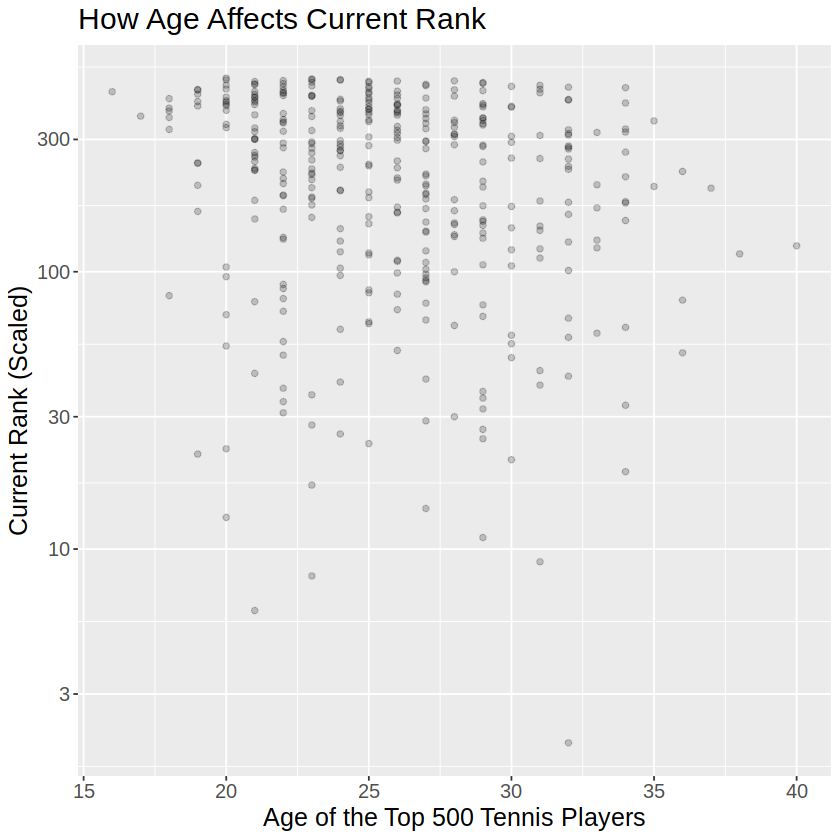

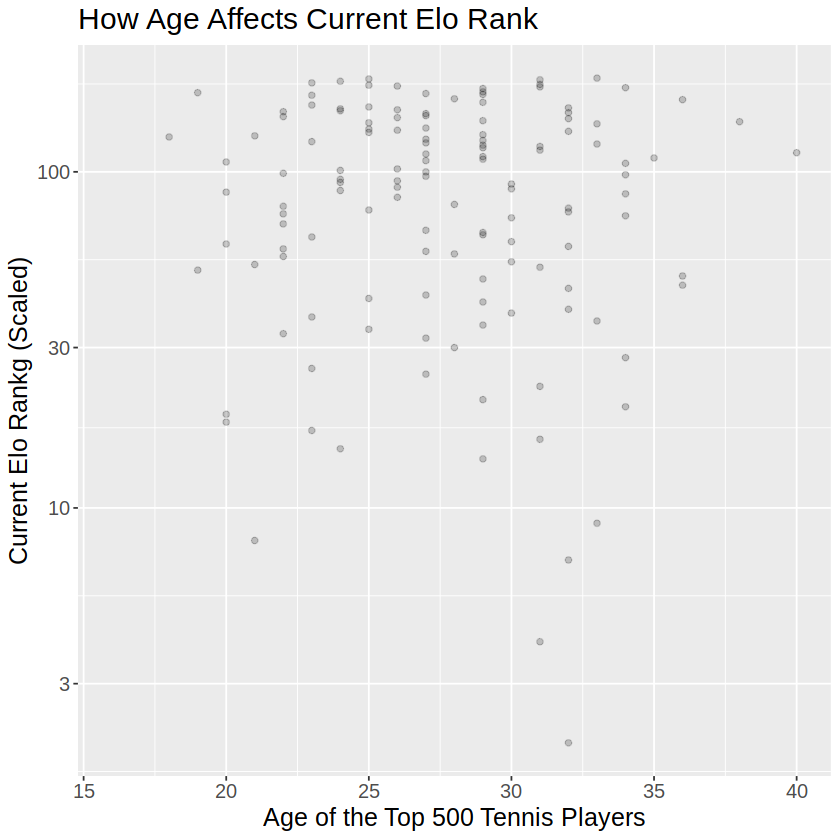

In [29]:
#Three Initial Scatter Plots
age_money_plot <- player_training |>
    ggplot(aes(x=age, y= prize_money))+
    geom_point(alpha=0.2)+
    labs(x="Age of the Top 500 Tennis Players", y= "Prize Money (Scaled)") +
    scale_y_log10() +
    ggtitle("How Age Affects Prize Money") +
    theme(text = element_text(size=15))
age_money_plot

age_rank_plot <- player_training |>
    ggplot(aes(x=age, y= current_rank))+
    geom_point(alpha=0.2)+
    labs(x="Age of the Top 500 Tennis Players", y= "Current Rank (Scaled)") +
    scale_y_log10() +
    ggtitle("How Age Affects Current Rank") +
    theme(text = element_text(size=15))
age_rank_plot

age_elo_plot <- player_training |>
    ggplot(aes(x=age, y= current_elo_rank))+
    geom_point(alpha=0.2)+
    labs(x="Age of the Top 500 Tennis Players", y= "Current Elo Rankg (Scaled)") +
    scale_y_log10() +
    ggtitle("How Age Affects Current Elo Rank")+
    theme(text = element_text(size=15))
age_elo_plot